In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
import oceans.ocfis

###
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s

def spectrum3(h, dt=1, nsmooth=5):
    """
    Detrend first.
    """
    t = np.arange(len(h))
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return spectrum2(h_detrended, dt=dt, nsmooth=nsmooth)

def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

def spectrum4(h, dt=1, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    h_detrended = detrend(h)
    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=dt, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [2]:
### Info of SD-1042's merged adcp data
year = '2023'
platf_num = '1042'
path_cur_SD = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
tlim_plot = [datetime.datetime(int(year),10,19), datetime.datetime(int(year),11,17)] ### 2023 SD1042
tint = 3
nt_plot = int((tlim_plot[1]-tlim_plot[0]).days)
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nt_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
print(tticks_label)
### load adcp data
ds_cur_SD = nc.Dataset(path_cur_SD+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_cur_SD.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
print(ds_cur_SD)
vars_str = ['longitude','latitude','vel_east','vel_north','depth']
for i in range( len(vars_str) ):
    temp = ds_cur_SD.variables[vars_str[i]][:]
    temp.filled(np.nan)
    exec( vars_str[i]+' = temp')
del time

['10/19', '10/20', '10/21', '10/22', '10/23', '10/24', '10/25', '10/26', '10/27', '10/28', '10/29', '10/30', '10/31', '11/01', '11/02', '11/03', '11/04', '11/05', '11/06', '11/07', '11/08', '11/09', '11/10', '11/11', '11/12', '11/13', '11/14', '11/15', '11/16']
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2023 SD-1042
    subtitle: Only selected variables for adcp measurements are here. Temporal resolution is ~10-minute.
    dimensions(sizes): depth(50), time(6154), beam(4)
    variables(dimensions): float64 depth(depth), float64 time(time), float64 longitude(time), float64 latitude(time), float64 pitch(time), float64 roll(time), float64 heading(time), float64 vehicle_vel_east(time), float64 vehicle_vel_north(time), float64 vehicle_vel_up(time), float64 bt_vel_east(time), float64 bt_vel_north(time), float64 bt_vel_up(time), float64 vel_east(time, depth), float64 vel_north(time, depth), float64 vel_up(time, dep

(6154,) (6154,)
is time_out monotonic? --> True
(6154,) (6154,)
<class 'tuple'> 2 [417600. 417605. 417610. ... 459270. 459300. 459330.]


<Figure size 432x288 with 0 Axes>

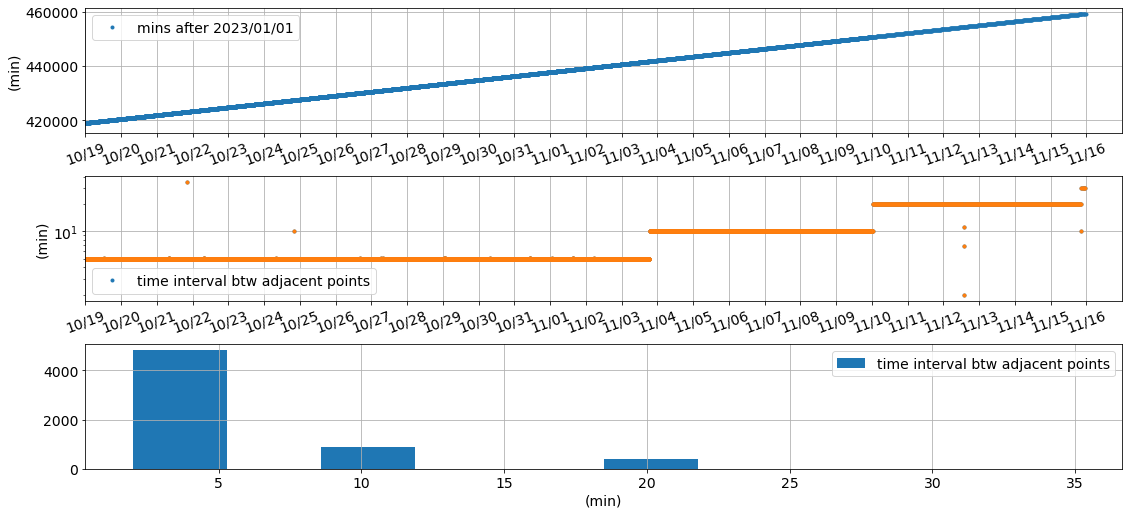

In [3]:
### compute the time as seconds since year-01-01
time_out = np.array([(dtime_cur_SD[i]-datetime.datetime(int(year),1,1)).total_seconds()/60 for i in range(len(dtime_cur_SD))])
print(dtime_cur_SD.shape, time_out.shape)
### check if time is monotonic and unique
def isMonotonic(A):
    return (all(A[i] <= A[i + 1] for i in range(len(A) - 1)) or
            all(A[i] >= A[i + 1] for i in range(len(A) - 1)))
print('is time_out monotonic? -->', isMonotonic(time_out))

nrow = 3
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrow,1, figsize=(18, 8))
plt.subplot(nrow,1,1)
plt.plot(dtime_cur_SD,time_out,'.',label='mins after '+year+'/01/01')
plt.ylabel('(min)'); plt.legend()
plt.subplot(nrow,1,2)
plt.semilogy(dtime_cur_SD[:-1],np.diff(np.sort(time_out)),'.',label='time interval btw adjacent points')
plt.semilogy(dtime_cur_SD[:-1],np.diff(time_out),'.')
plt.ylabel('(min)'); plt.legend()
plt.subplot(nrow,1,3)
plt.hist(np.diff(np.sort(time_out)),label='time interval btw adjacent points')
plt.xlabel('(min)'); plt.legend()
### figure settings
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.grid()
    if i< 2:
        plt.xticks(tticks)
        plt.gca().set_xticklabels(tticks_label,rotation=20)
        plt.xlim(tlim_plot)
print(np.unique(time_out).shape, time_out.shape)
test = np.unique(time_out, return_index=False, return_inverse=False, return_counts=True)
print(type(test), len(test), test[0])
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)


In [4]:
""" The temporal interval is 5 min, 10 min, or more between 10/19 & 10/16
--> Let's linear interpolate the velocity to 15 minute grid before compute the spectra
"""
nt = ((tlim_plot[1]-tlim_plot[0]).days) * int(3600/15)
timestamp_cur_SD = np.array([dtime_cur_SD[i].timestamp() for i in range(len(dtime_cur_SD))])
dtime_cur_SD_intp = np.array([tlim_plot[0]+datetime.timedelta(minutes=i*15) for i in range(nt)])
timestamp_cur_SD_intp = np.array([dtime_cur_SD_intp[i].timestamp() for i in range(len(dtime_cur_SD_intp))])
vel_east_intp = np.nan*np.ones( (len(dtime_cur_SD_intp),len(depth)) )
vel_north_intp = vel_east_intp.copy()
for z in range( len(depth) ):
    isok = ~np.isnan(vel_east[:,z])
    vel_east_intp[:,z] = np.interp( timestamp_cur_SD_intp, timestamp_cur_SD[isok], vel_east[isok,z])
    vel_north_intp[:,z] = np.interp( timestamp_cur_SD_intp, timestamp_cur_SD[isok], vel_north[isok,z])

<Figure size 432x288 with 0 Axes>

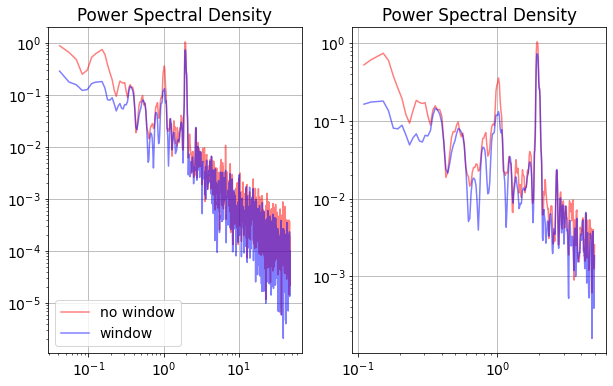

In [5]:
### compute and plot spectra
data = vel_east_intp[:,0]
freqs1, ps1, psd1 = spectrum4(data, dt=1)
freqs1a, ps1a, psd1a = spectrum3(data, dt=1)
freqs1_cpd = freqs1/(15*60)*86400
freqs1a_cpd = freqs1a/(15*60)*86400

### plot
ncol = 2
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(ncols=2)
plt.gcf().set_size_inches(10,6)
###
axs[0].loglog(freqs1_cpd, psd1a, 'r', alpha=0.5, label='no window')
axs[0].loglog(freqs1_cpd, psd1, 'b', alpha=0.5, label='window')
# axs[0].axis('tight', which='x')
axs[0].grid()
axs[0].legend(loc='lower left')
axs[0].set_title('Power Spectral Density')
###
i0, i1 = np.searchsorted(freqs1_cpd, [0.1, 5])
sl = slice(i0, i1)
axs[1].loglog(freqs1_cpd[sl], psd1a[sl], 'r', 
              freqs1_cpd[sl], psd1[sl], 'b', alpha=0.5)
# axs[1].axis('tight', which='x')
axs[1].grid()
axs[1].set_title('Power Spectral Density');

In [ ]:
os.path.exists(path_cur_SD)

True